# ¡El gran proyecto comienza!

## El tasador de productos

Un modelo que puede estimar cuánto cuesta algo a partir de su descripción.

## Curación de datos, parte 1

Hoy comenzaremos a depurar y curar nuestro conjunto de datos centrándonos en un subconjunto de los datos: electrodomésticos.

El conjunto de datos está aquí:
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023

Y la carpeta con todos los conjuntos de datos de productos está aquí:
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/tree/main/raw/meta_categories

In [1]:
# imports

import os
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt

In [2]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [3]:
# Log in en HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [4]:
# Una importación más: la clase Item
# Si recibe un error que indica que debe aceptar los términos de Meta cuando ejecuta esto, siga el enlace que le proporciona y siga sus instrucciones
# Meta debería aprobarlo en unos minutos
# Si tiene algún problema, envíeme un mensaje o un correo electrónico.
# Agradezco al estudiante Dr. John S. por señalar que esta importación debe realizarse después de iniciar sesión en HF

from items import Item

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

In [5]:
%matplotlib inline

In [6]:
# Load in our dataset

dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", f"raw_meta_Appliances", split="full", trust_remote_code=True)

README.md:   0%|          | 0.00/19.7k [00:00<?, ?B/s]

Amazon-Reviews-2023.py:   0%|          | 0.00/39.6k [00:00<?, ?B/s]

meta_Appliances.jsonl:   0%|          | 0.00/285M [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

In [7]:
print(f"Número de electrodomésticos: {len(dataset):,}")

Número de electrodomésticos: 94,327


In [12]:
# Investigate un punto de datos concreto
datapoint = dataset[2]


In [13]:
# Investigar

print(datapoint["title"])
print(datapoint["description"])
print(datapoint["features"])
print(datapoint["details"])
print(datapoint["price"])

Clothes Dryer Drum Slide, General Electric, Hotpoint, WE1M333, WE1M504
['Brand new dryer drum slide, replaces General Electric, Hotpoint, RCA, WE1M333, WE1M504.']
[]
{"Manufacturer": "RPI", "Part Number": "WE1M333,", "Item Weight": "0.352 ounces", "Package Dimensions": "5.5 x 4.7 x 0.4 inches", "Item model number": "WE1M333,", "Is Discontinued By Manufacturer": "No", "Item Package Quantity": "1", "Batteries Included?": "No", "Batteries Required?": "No", "Best Sellers Rank": {"Tools & Home Improvement": 1315213, "Parts & Accessories": 181194}, "Date First Available": "February 25, 2014"}
None


In [14]:
# ¿Cuantos tienen precios?

prices = 0
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            prices += 1
    except ValueError as e:
        pass

print(f"Hay {prices:,} con precio lo cual representa un {prices/len(dataset)*100:,.1f}%")

Hay 46,726 con precio lo cual representa un 49.5%


In [15]:
# Para aquellos que tienen precios, recopilen el precio y la longitud.

prices = []
lengths = []
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            prices.append(price)
            contents = datapoint["title"] + str(datapoint["description"]) + str(datapoint["features"]) + str(datapoint["details"])
            lengths.append(len(contents))
    except ValueError as e:
        pass

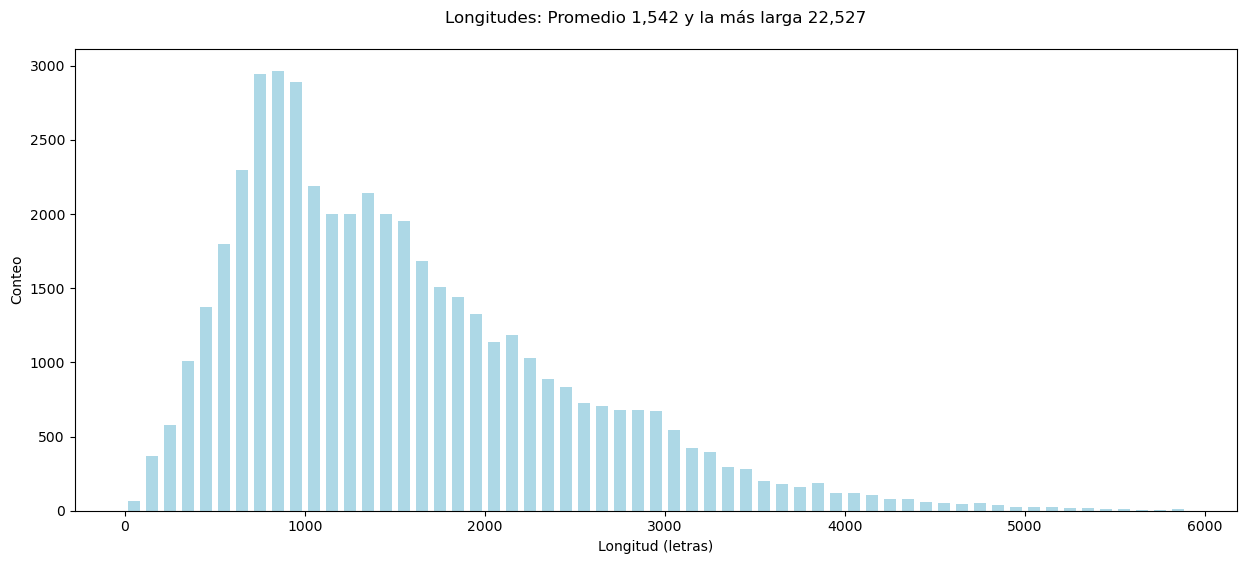

In [16]:
#Representamos la distribución de la longitud

plt.figure(figsize=(15, 6))
plt.title(f"Longitudes: Promedio {sum(lengths)/len(lengths):,.0f} y la más larga {max(lengths):,}\n")
plt.xlabel('Longitud (letras)')
plt.ylabel('Conteo')
plt.hist(lengths, rwidth=0.7, color="lightblue", bins=range(0, 6000, 100))
plt.show()

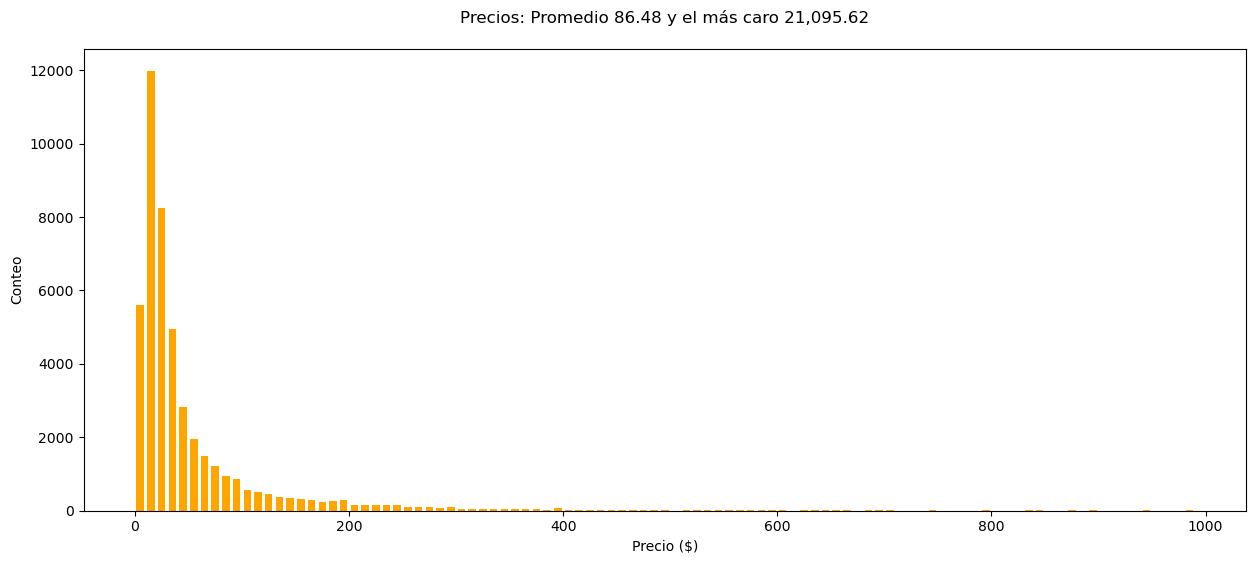

In [17]:
# Representamos la distribución de los precios

plt.figure(figsize=(15, 6))
plt.title(f"Precios: Promedio {sum(prices)/len(prices):,.2f} y el más caro {max(prices):,}\n")
plt.xlabel('Precio ($)')
plt.ylabel('Conteo')
plt.hist(prices, rwidth=0.7, color="orange", bins=range(0, 1000, 10))
plt.show()

In [18]:
# ¿Quál es ese ítem?

for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 21000:
            print(datapoint['title'])
    except ValueError as e:
        pass

TurboChef BULLET Rapid Cook Electric Microwave Convection Oven


Esto es lo más parecido que puedo encontrar. ¡Parece que se vende a un precio de ganga!

https://www.amazon.com/TurboChef-Electric-Countertop-Microwave-Convection/dp/B01D05U9NO/

## Ahora es momento de seleccionar nuestro conjunto de datos

Seleccionamos elementos que cuestan entre 1 y 999 USD

Crearemos instancias de elementos, que truncarán el texto para que quepa en 180 tokens utilizando el Tokenizador adecuado

Y crearemos un mensaje para usar durante el entrenamiento.

Los elementos serán rechazados si no tienen suficientes caracteres.

## Pero, ¿por qué 180 tokens?

Un estudiante me hizo una gran pregunta: ¿por qué estamos truncando a 180 tokens? ¿Cómo determinamos ese número? (Gracias Moataz A. por la excelente pregunta).

La respuesta: este es un ejemplo de un "hiperparámetro". En otras palabras, ¡es básicamente prueba y error! Queremos una cantidad de tokens lo suficientemente grande como para tener suficiente información útil para medir el precio. Pero también queremos mantener la cantidad baja para poder entrenar de manera eficiente. Verás esto en acción en la semana 7.

Comencé con un número que parecía razonable y experimenté con algunas variaciones antes de decidirme por 180. Si tienes tiempo, ¡deberías hacer lo mismo! Es posible que descubras que puedes superar mis resultados si encuentras un mejor equilibrio. Este tipo de prueba y error puede sonar un poco insatisfactorio, pero es una parte crucial del proceso de I+D de la ciencia de datos.

Hay otra razón interesante por la que podríamos favorecer una cantidad menor de tokens en los datos de entrenamiento. Cuando finalmente podamos usar nuestro modelo en el momento de la inferencia, querremos proporcionar nuevos productos y hacer que calcule un precio. Y usaremos descripciones breves de los productos, como 1 o 2 oraciones. Para obtener el mejor rendimiento, debemos dimensionar nuestros datos de entrenamiento para que sean similares a las entradas que proporcionaremos en el momento de la inferencia.

## Pero veo que en items.py restringe las entradas a 160 tokens.

¡Otra gran pregunta de Moataz A.! La descripción de los productos está limitada a 160 tokens porque agregamos más texto antes y después de la descripción para convertirla en un mensaje. Eso hace que el total sea de aproximadamente 180 tokens.

In [19]:
# Crea un objeto de artículo para cada uno con un precio

items = []
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            item = Item(datapoint, price)
            if item.include:
                items.append(item)
    except ValueError as e:
        pass

print(f"Hay {len(items):,} items")

Hay 29,191 items


In [24]:
# Miramos el primer ítem

items[100]

<Samsung DA97-02203H Assembly Ice Maker-Mech = $118.35>

In [23]:
# Investigamos el mensaje que se utilizará durante el entrenamiento: el modelo aprende a completarlo.

print(items[100].prompt)

How much does this cost to the nearest dollar?

Samsung Assembly Ice Maker-Mech
This is an O.E.M. Authorized part, fits with various Samsung brand models, oem part # this product in manufactured in south Korea. This is an O.E.M. Authorized part Fits with various Samsung brand models Oem part # This is a Samsung replacement part Part Number This is an O.E.M. part Manufacturer J&J International Inc., Part Weight 1 pounds, Dimensions 18 x 12 x 6 inches, model number Is Discontinued No, Color White, Material Acrylonitrile Butadiene Styrene, Quantity 1, Certification Certified frustration-free, Included Components Refrigerator-replacement-parts, Rank Tools & Home Improvement Parts & Accessories 31211, Available April 21, 2011

Price is $118.00


In [25]:
# Investigamos el mensaje que se utilizará durante el testing: el modelo debe adivinarlo.

print(items[100].test_prompt())

How much does this cost to the nearest dollar?

Samsung Assembly Ice Maker-Mech
This is an O.E.M. Authorized part, fits with various Samsung brand models, oem part # this product in manufactured in south Korea. This is an O.E.M. Authorized part Fits with various Samsung brand models Oem part # This is a Samsung replacement part Part Number This is an O.E.M. part Manufacturer J&J International Inc., Part Weight 1 pounds, Dimensions 18 x 12 x 6 inches, model number Is Discontinued No, Color White, Material Acrylonitrile Butadiene Styrene, Quantity 1, Certification Certified frustration-free, Included Components Refrigerator-replacement-parts, Rank Tools & Home Improvement Parts & Accessories 31211, Available April 21, 2011

Price is $


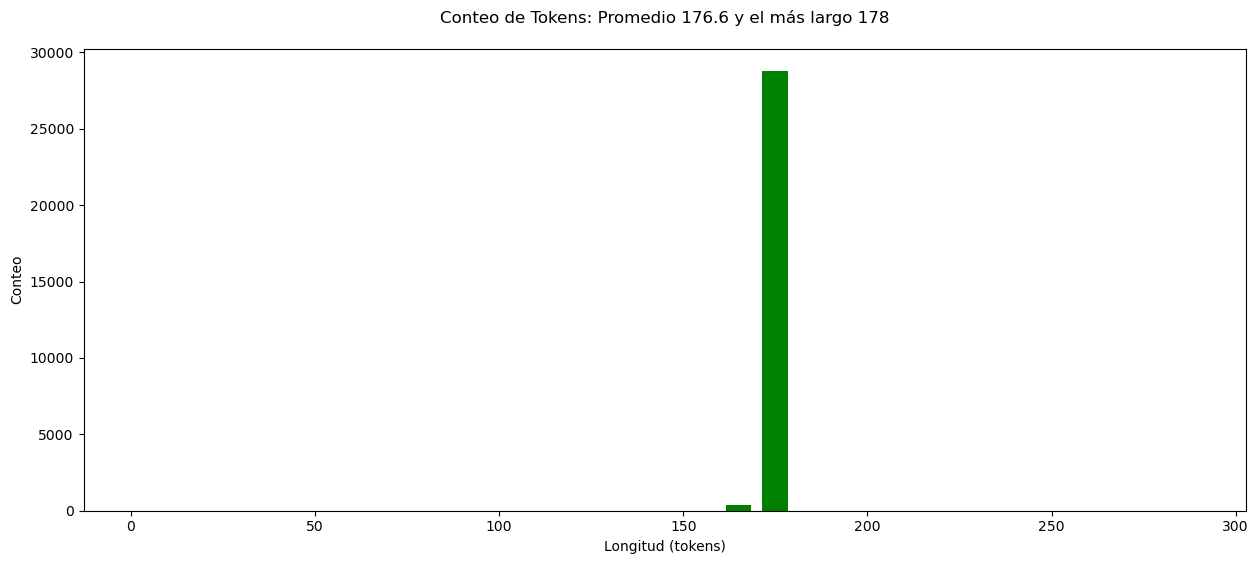

In [26]:
# Representamos la distribución de los recuentos de tokens

tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Conteo de Tokens: Promedio {sum(tokens)/len(tokens):,.1f} y el más largo {max(tokens):,}\n")
plt.xlabel('Longitud (tokens)')
plt.ylabel('Conteo')
plt.hist(tokens, rwidth=0.7, color="green", bins=range(0, 300, 10))
plt.show()

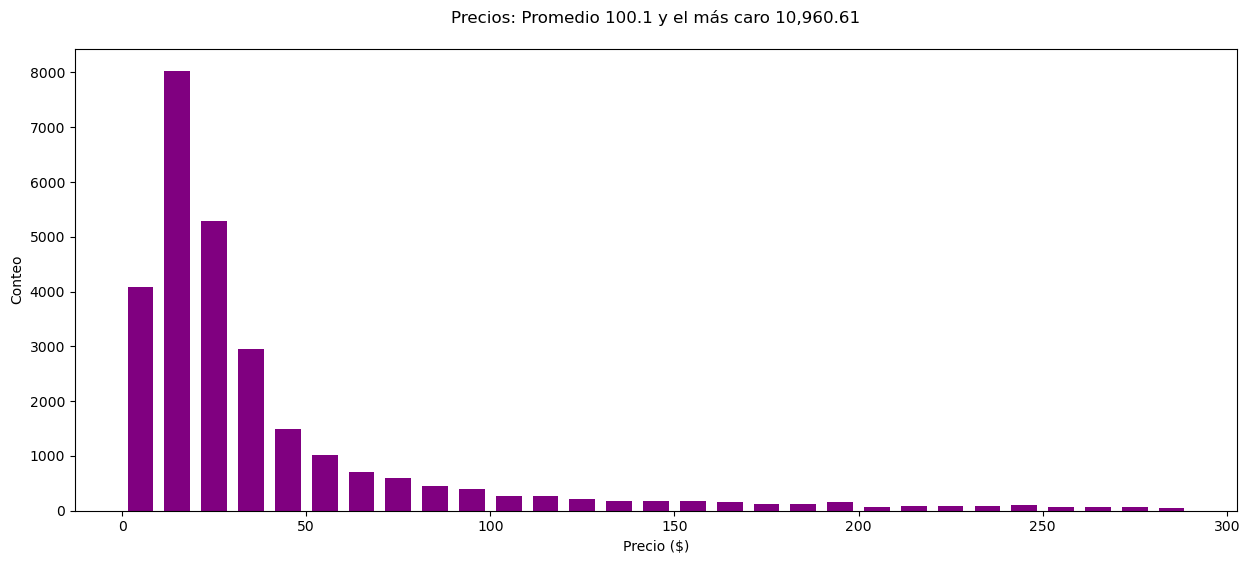

In [27]:
# Representamos la distribución de los precios

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Precios: Promedio {sum(prices)/len(prices):,.1f} y el más caro {max(prices):,}\n")
plt.xlabel('Precio ($)')
plt.ylabel('Conteo')
plt.hist(prices, rwidth=0.7, color="purple", bins=range(0, 300, 10))
plt.show()

## Nota al margen

Si te gusta la variedad de colores que matplotlib puede usar en sus gráficos, deberías marcar esto como favorito:

https://matplotlib.org/stable/gallery/color/named_colors.html

## Tareas pendientes para ti:

- Revisa la clase Item y comprueba que te sientes cómodo con ella
- Examina algunos objetos Item, mira el mensaje de entrenamiento con `item.prompt` y el mensaje de prueba con `item.test_prompt()`
- Haz algunos histogramas más para entender mejor los datos

## La próxima vez combinaremos con muchos otros tipos de productos

como productos electrónicos y automotrices. Esto nos dará un conjunto de datos masivo y luego podremos ser selectivos al elegir un subconjunto que sea más adecuado para el entrenamiento.